
<div style="padding:18px;border:2px solid #e8eaed;border-radius:12px;background:#fcfcff">
  <h1 style="margin:0;color:#1a73e8">NLP Disaster Tweets — Week 4 Mini‑Project (BiLSTM)</h1>
  <p style="margin:6px 0 0 0;color:#5f6368">
    A tidy, single‑family approach: <b>Tokenizer → Embedding → Bidirectional LSTM</b> with a small, staged HPO.
  </p>
</div>

<details style="margin-top:8px">
  <summary><b>Roadmap</b> (click)</summary>
  <ol>
    <li>Brief description (problem & data)</li>
    <li>EDA → cleaning decisions</li>
    <li>Model architecture (BiLSTM) & rationale</li>
    <li>Experiments & small HPO</li>
    <li>Results, analysis & conclusion</li>
    <li>Submission & references</li>
  </ol>
</details>



## 1) Brief description of the problem and data 

**Description of the Problem and NLP Context**

This project is based on the Kaggle *Natural Language Processing with Disaster Tweets* competition, where the task is to automatically classify short text messages (tweets) as either describing a real disaster (`target = 1`) or not related to a disaster (`target = 0`).

**Dataset Overview**
- **Train set**: ~7,600 tweets, each with an ID, text content, optional keyword, optional location, and the binary target.  
- **Test set**: ~3,300 tweets, same structure without the target.  
- Tweets are short (median length ~15–20 tokens) and written in informal, noisy language with abbreviations, hashtags, mentions, and URLs.

This problem falls under the field of **Natural Language Processing (NLP)**, which involves techniques for processing and analyzing human language so that computers can understand and act on it. Specifically, it is a **binary text classification** problem.

---

**Project Plan Overview**

We will:
1. **Explore and clean the data** – Inspect text lengths, class balance, and patterns; apply minimal cleaning (lowercase, replace URLs/mentions, keep hashtag words).  
2. **Convert text to numeric form** – Use tokenization and a learned embedding layer to map words into dense vectors suitable for neural networks.  
3. **Build and train a sequential neural network** – Main model: Bidirectional LSTM, chosen to capture both past and future context in a tweet.  
4. **Hyperparameter tuning** – Run a small, staged search over sequence length, pooling type, hidden units, learning rate, and dropout to find the best-performing setup.  
5. **Evaluate and analyze results** – Compare model variants by AUC (primary metric) and accuracy (secondary); discuss what improved performance and what didn’t.  
6. **Produce deliverables** – Submit predictions to Kaggle, include a leaderboard screenshot, and push the cleaned notebook to a public GitHub repository.



## 2) Setup — imports, config, helpers


In [2]:
# Imports
import os, re, random, gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score  # + f1

# Style (optional)
from IPython.display import display, HTML
def h2(txt): display(HTML(f'<h2 style="color:#1a73e8">{txt}</h2>'))
def note(msg): display(HTML(f'<div style="padding:10px;border-left:4px solid #1a73e8;background:#f1f5ff">{msg}</div>'))

# Reproducibility
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

# Config
CFG = {
    "seed": 42,
    "subset_rows": 0,         # 0 = use all; >0 = use only first N rows for quick local tests
    "val_size": 0.15,         # validation split from train
    "max_len": 50,            # will be tuned in HPO
    "batch_size": 32,
    "epochs": 6,
    "learning_rate": 1e-3,
    "embedding_dim": 100,
    "units": 64,
    "dropout": 0.2,
    "paths": {
        "train": "data/train.csv",
        "test": "data/test.csv",
        "submission": "submissions/sub.csv"
    },
    "metric": "f1",                       # Kaggle leaderboard metric
    "kaggle_competition": "nlp-getting-started"
}

# Create dirs, set seed
os.makedirs(os.path.dirname(CFG["paths"]["submission"]), exist_ok=True)
set_seed(CFG["seed"])

# Determinism + safer GPU memory handling (best-effort)
try:
    tf.config.experimental.enable_op_determinism()
except Exception:
    pass
_gpus = tf.config.list_physical_devices('GPU')
for _g in _gpus:
    try:
        tf.config.experimental.set_memory_growth(_g, True)
    except Exception:
        pass

print("TensorFlow:", tf.__version__)
print("Num GPUs:", len(_gpus))

2025-08-12 14:55:02.058164: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-12 14:55:02.100536: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-12 14:55:02.100564: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-12 14:55:02.100589: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-12 14:55:02.108621: I tensorflow/core/platform/cpu_feature_g

TensorFlow: 2.14.0
Num GPUs: 1


### Download the data from Kaggle

In [3]:
# Kaggle download helper
import subprocess, pathlib

def download_kaggle_data():
    data_dir = pathlib.Path("data")
    data_dir.mkdir(exist_ok=True)
    print(f"Downloading competition data to {data_dir}...")
    subprocess.run([
        "kaggle", "competitions", "download",
        "-c", CFG["kaggle_competition"],
        "-p", str(data_dir)
    ], check=True)
    subprocess.run(["unzip", "-o", str(data_dir/f"{CFG['kaggle_competition']}.zip"), "-d", str(data_dir)], check=True)
    print("Download complete:", sorted(p.name for p in data_dir.glob("*.csv")))

download_kaggle_data()


Archive:  data/nlp-getting-started.zip
  inflating: data/sample_submission.csv  
  inflating: data/test.csv           
  inflating: data/train.csv          
Download complete: ['sample_submission.csv', 'test.csv', 'train.csv']


100%|██████████| 593k/593k [00:00<00:00, 46.7MB/s]



## 3) EDA — inspect, visualize, decide cleaning


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


target
0    0.57034
1    0.42966
Name: ratio, dtype: float64

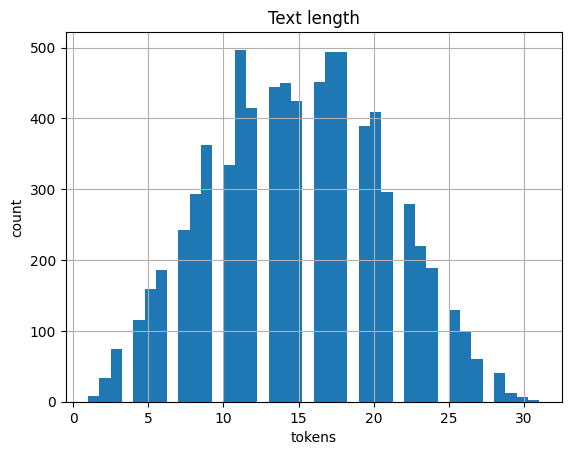

In [5]:
# Load
train_df = pd.read_csv(CFG["paths"]["train"])
test_df  = pd.read_csv(CFG["paths"]["test"])

# Subset for quick local testing
if CFG["subset_rows"] and CFG["subset_rows"] > 0:
    train_df = train_df.iloc[:CFG["subset_rows"]].copy()
    test_df  = test_df.iloc[: min(CFG["subset_rows"], len(test_df))].copy()

h2("Preview")
display(train_df.head())
display(test_df.head())

h2("Class balance (train)")
if "target" in train_df.columns:
    display(train_df["target"].value_counts(normalize=True).rename("ratio"))

h2("Text length")
train_df["text_len"] = train_df["text"].astype(str).str.split().map(len)
plt.figure()
train_df["text_len"].hist(bins=40)
plt.title("Text length")
plt.xlabel("tokens")
plt.ylabel("count")
plt.show()

## EDA Summary (Train Set)

- **Class Balance**
  - `target = 0`: ~57%
  - `target = 1`: ~43%
  - → Modest class imbalance, but not severe enough to require heavy rebalancing techniques.

- **Text Length**
  - Most tweets are between **10–22 tokens**.
  - Median length ≈ 15–16 tokens.
  - Very few tweets exceed 30 tokens.

- **Keyword & Location Fields**
  - High proportion of missing values in both fields.
  - `keyword` may contain informative disaster-related terms.
  - `location` is noisy and sparse, likely requiring cleaning or grouping to be useful.

- **Overall Impression**
  - Tweets are short and concise.
  - Token length distribution is fairly symmetric.
  - Primary signal will likely come from the `text` column, with optional engineered features from `keyword` and `location`.

## Next Steps for Processing/Cleaning
1. Lowercase all text.
2. Replace URLs with `<URL>` and @mentions with `<USER>`.
3. Strip `#` but keep the hashtag word (e.g., `#earthquake` → `earthquake`).
4. Normalize punctuation (do not delete):
   - Keep apostrophes (negations matter: “don’t” ≠ “do”).
   - Collapse repeated punctuation (`!!!` → `!`) and extra whitespace.
5. Unicode normalize (NFC) and trim leading/trailing spaces.
6. Keep digits as-is (numbers often carry disaster-related meaning like counts, magnitudes, road IDs).


## 4) Cleaning & split


In [7]:
import re
import unicodedata

def basic_clean(s: str) -> str:
    # Lowercase
    s = s.lower()

    # Replace URLs and @mentions
    s = re.sub(r"http\S+|www\.\S+", " <url> ", s)
    s = re.sub(r"@\w+", " <user> ", s)

    # Keep hashtag words but strip '#'
    s = re.sub(r"#(\w+)", r" \1 ", s)

    # Unicode normalize
    s = unicodedata.normalize("NFC", s)

    # Collapse repeated punctuation (keep apostrophes)
    s = re.sub(r"([!?.,])\1+", r"\1", s)  # !!! → !
    
    # Collapse extra whitespace
    s = re.sub(r"\s+", " ", s).strip()

    return s

# Apply cleaning
train_df["text_clean"] = train_df["text"].astype(str).map(basic_clean)
test_df["text_clean"]  = test_df["text"].astype(str).map(basic_clean)

# Stratified split
from sklearn.model_selection import train_test_split
train_tmp, val_df = train_test_split(
    train_df,
    test_size=CFG["val_size"],
    stratify=train_df["target"],
    random_state=CFG["seed"]
)
y_train = train_tmp["target"].values
y_val   = val_df["target"].values

print("Section summary — Cleaning:")
print("- Lowercased, replaced URLs and mentions with placeholders, kept hashtag words, normalized punctuation, collapsed spaces.")
print("- Created train/validation split (stratified).")

Section summary — Cleaning:
- Lowercased, replaced URLs and mentions with placeholders, kept hashtag words, normalized punctuation, collapsed spaces.
- Created train/validation split (stratified).



## 5) Model architecture & rationale

The task is to decide if a short tweet is about a **real disaster** or **not**.  
Tweets are messy—full of hashtags, mentions, URLs, and informal language—so the model needs to capture both **content** and **word order**.

We preprocess by tokenizing each tweet into integers, padding sequences to the same length, and passing them through a learned embedding layer that trains alongside the classification task. We avoid TF-IDF because it ignores word order, instead using a sequential neural network to capture both meaning and context.
The embedding layer starts with random vectors for each token and updates them during training so that words used in similar contexts have similar vector representations.

Our main model is a **Bidirectional LSTM**:
- Reads the tweet forwards and backwards for richer context.
- LSTM handles sequences well and remembers important parts.
- We test two pooling approaches:
  1. Last hidden state – full sequence summary.
  2. Global Max Pooling – strongest features anywhere in the tweet.
- A final dense sigmoid layer outputs the probability of a disaster.

Training uses binary cross-entropy loss, Adam optimizer (LR = 1e-3 and 5e-4), early stopping, and learning-rate reduction. AUC is our main evaluation metric, with accuracy as a secondary check.

This setup works well for tweets because they are short, making bidirectional processing fast, and because word order matters (“not a fire” ≠ “fire in the park”). Pooling comparisons will reveal whether overall context or key words matter more.

We will also compare with a GRU model, adjust sequence length, hidden units, and dropout to explore model variations. From this we expect to learn how pooling affects performance, how to balance size and regularization, and whether GRU can match or beat LSTM. Future steps may include adding attention, using pretrained embeddings like GloVe, or testing a small transformer.


## 6) Functions — tokenize → pad, build BiLSTM/GRU, train & evaluate


In [12]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_recall_curve
from typing import Dict


def fit_tokenizer(texts: pd.Series):
    tok = keras.preprocessing.text.Tokenizer(num_words=None, oov_token="<oov>")
    tok.fit_on_texts(texts)
    return tok

def to_padded(tok, texts: pd.Series, max_len: int):
    seqs = tok.texts_to_sequences(texts)
    return keras.preprocessing.sequence.pad_sequences(seqs, maxlen=max_len)

def build_rnn(cfg: Dict, vocab_size: int, *, cell="lstm", pool="last", units=None, dropout=None, lr=None):
    units   = units   if units   is not None else cfg["units"]
    dropout = dropout if dropout is not None else cfg["dropout"]
    lr      = lr      if lr      is not None else cfg["learning_rate"]

    inputs = layers.Input(shape=(cfg["max_len"],))
    x = layers.Embedding(vocab_size+1, cfg["embedding_dim"])(inputs)
    RNN = layers.LSTM if cell=="lstm" else layers.GRU
    x = layers.Bidirectional(RNN(units, return_sequences=(pool!="last")))(x)
    if dropout and dropout>0: x = layers.Dropout(dropout)(x)
    if pool == "gmp": x = layers.GlobalMaxPooling1D()(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    m = keras.Model(inputs, outputs)
    m.compile(optimizer=keras.optimizers.Adam(lr), loss="binary_crossentropy",
              metrics=["accuracy", keras.metrics.AUC(name="auc")])
    return m


def train_and_eval(model, Xtr, ytr, Xva, yva, cfg: Dict):
    callbacks = [
        keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5, verbose=1),
        keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, verbose=1),
    ]
    hist = model.fit(
        Xtr, ytr,
        validation_data=(Xva, yva),
        epochs=cfg["epochs"],
        batch_size=cfg["batch_size"],
        verbose=1,
        callbacks=callbacks
    )

    # Predict on validation set
    y_prob = model.predict(Xva, batch_size=cfg["batch_size"]).ravel()

    # Find best threshold by F1 score
    prec, rec, thr = precision_recall_curve(yva, y_prob)
    f1s = 2 * prec * rec / (prec + rec + 1e-12)
    best_idx = f1s[:-1].argmax() if len(thr) else 0
    best_t = float(thr[best_idx]) if len(thr) else 0.5

    # Apply best threshold
    y_pred = (y_prob >= best_t).astype(int)

    # Compute metrics
    acc = accuracy_score(yva, y_pred)
    auc = roc_auc_score(yva, y_prob)
    f1  = f1_score(yva, y_pred)

    # Print summary line
    print(f"Best F1={f1:.4f} at threshold={best_t:.3f} | AUC={auc:.4f} ACC={acc:.4f}")

    return {
        "acc": acc,
        "auc": auc,
        "f1": f1,
        "best_t": best_t,
        "history": hist.history,
    }

print("Section summary — Functions:")
print("- Tokenizer + padding to fixed sequence length.")
print("- Build BiLSTM/GRU with selectable pooling, units, dropout, and learning rate.")
print("- Train with EarlyStopping & ReduceLROnPlateau; report AUC/Accuracy.")


Section summary — Functions:
- Tokenizer + padding to fixed sequence length.
- Build BiLSTM/GRU with selectable pooling, units, dropout, and learning rate.
- Train with EarlyStopping & ReduceLROnPlateau; report AUC/Accuracy.



## 7) Quick sanity run (small BiLSTM)


In [13]:

CFG["max_len"] = 40
tok = fit_tokenizer(train_tmp["text_clean"])
Xtr = to_padded(tok, train_tmp["text_clean"], CFG["max_len"])
Xva = to_padded(tok, val_df["text_clean"],   CFG["max_len"])

model = build_rnn(CFG, vocab_size=len(tok.word_index), cell="lstm", pool="last", units=64, dropout=0.2, lr=1e-3)
metrics0 = train_and_eval(model, Xtr, y_train, Xva, y_val, CFG)
print("Sanity run — AUC:", metrics0["auc"], "ACC:", metrics0["acc"])

print("Section summary — Sanity run:\n- Verified end‑to‑end flow on small BiLSTM.\n- Proceed to staged HPO.")


2025-08-12 16:11:49.180652: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43694 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:d2:00.0, compute capability: 8.6
2025-08-12 16:11:49.322633: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Epoch 1/6


2025-08-12 16:11:52.724236: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8905
2025-08-12 16:11:55.037342: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x74ec00499ed0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-08-12 16:11:55.037380: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A40, Compute Capability 8.6
2025-08-12 16:11:55.045828: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-08-12 16:11:55.154296: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


203/203 [==============================] - 36s 150ms/step - loss: 0.5340 - accuracy: 0.7336 - auc: 0.7893 - val_loss: 0.4415 - val_accuracy: 0.8117 - val_auc: 0.8682 - lr: 0.0010
Epoch 2/6
203/203 [==============================] - 11s 56ms/step - loss: 0.3056 - accuracy: 0.8781 - auc: 0.9324 - val_loss: 0.4539 - val_accuracy: 0.8082 - val_auc: 0.8597 - lr: 0.0010
Epoch 3/6
203/203 [==============================] - ETA: 0s - loss: 0.1904 - accuracy: 0.9328 - auc: 0.9732
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
203/203 [==============================] - 8s 39ms/step - loss: 0.1904 - accuracy: 0.9328 - auc: 0.9732 - val_loss: 0.5487 - val_accuracy: 0.7741 - val_auc: 0.8448 - lr: 0.0010
Epoch 4/6
203/203 [==============================] - 8s 38ms/step - loss: 0.1091 - accuracy: 0.9641 - auc: 0.9905 - val_loss: 0.6082 - val_accuracy: 0.7671 - val_auc: 0.8422 - lr: 5.0000e-04
Epoch 4: early stopping
36/36 [==============================] - 1s 5ms/step
Bes


## 8) HPO — Stage A: structure (max_len × pooling)


In [ ]:

results = []
for max_len, pool in [(40,"last"), (40,"gmp"), (60,"last"), (60,"gmp")]:
    CFG["max_len"] = max_len
    tok = fit_tokenizer(train_tmp["text_clean"])
    Xtr = to_padded(tok, train_tmp["text_clean"], max_len)
    Xva = to_padded(tok, val_df["text_clean"],   max_len)
    model = build_rnn(CFG, vocab_size=len(tok.word_index), cell="lstm", pool=pool, units=64, dropout=0.2, lr=1e-3)
    m = train_and_eval(model, Xtr, y_train, Xva, y_val, CFG)
    results.append({"stage":"A","max_len":max_len,"pool":pool,"units":64,"lr":1e-3,"dropout":0.2,"auc":m["auc"],"acc":m["acc"]})

df_results = pd.DataFrame(results).sort_values("auc", ascending=False)
display(df_results.head(10))

print("Section summary — Stage A:\n- Compared max_len {40,60} and pooling {last,GMP}.\n- Keeping the best combo by validation AUC.")



## 9) HPO — Stage B: capacity × learning rate


In [ ]:

bestA = df_results.iloc[0].to_dict()
best_max_len, best_pool = int(bestA["max_len"]), bestA["pool"]
CFG["max_len"] = best_max_len

tok = fit_tokenizer(train_tmp["text_clean"])
Xtr = to_padded(tok, train_tmp["text_clean"], best_max_len)
Xva = to_padded(tok, val_df["text_clean"],   best_max_len)

for units in [64, 128]:
    for lr in [1e-3, 5e-4]:
        model = build_rnn(CFG, vocab_size=len(tok.word_index), cell="lstm", pool=best_pool, units=units, dropout=0.2, lr=lr)
        m = train_and_eval(model, Xtr, y_train, Xva, y_val, CFG)
        results.append({"stage":"B","max_len":best_max_len,"pool":best_pool,"units":units,"lr":lr,"dropout":0.2,"auc":m["auc"],"acc":m["acc"]})

df_results = pd.DataFrame(results).sort_values(["stage","auc"], ascending=[True, False])
display(df_results[df_results["stage"]=="B"].sort_values("auc", ascending=False))

print("Section summary — Stage B:\n- Tuned units {64,128} and lr {1e‑3, 5e‑4} on best structure.\n- Select best by AUC.")



## 10) HPO — Stage C: regularization (dropout)


In [ ]:

best_overall = pd.DataFrame(results).sort_values("auc", ascending=False).iloc[0].to_dict()
CFG["max_len"] = int(best_overall["max_len"])

tok = fit_tokenizer(train_tmp["text_clean"])
Xtr = to_padded(tok, train_tmp["text_clean"], CFG["max_len"])
Xva = to_padded(tok, val_df["text_clean"],   CFG["max_len"])

for dp in [0.0, 0.3]:
    model = build_rnn(CFG, vocab_size=len(tok.word_index), cell="lstm",
                      pool=best_overall["pool"], units=int(best_overall["units"]), lr=float(best_overall["lr"]), dropout=dp)
    m = train_and_eval(model, Xtr, y_train, Xva, y_val, CFG)
    results.append({"stage":"C","max_len":CFG["max_len"],"pool":best_overall["pool"],
                    "units":int(best_overall["units"]),"lr":float(best_overall["lr"]),"dropout":dp,"auc":m["auc"],"acc":m["acc"]})

df_results = pd.DataFrame(results).sort_values("auc", ascending=False)
display(df_results.head(10))

print("Section summary — Stage C:\n- Tested dropout {0.0, 0.3} on the current best.\n- Best config fixed for final training and submission.")



## 11) (Optional) GRU variant


In [ ]:

best_now = pd.DataFrame(results).sort_values("auc", ascending=False).iloc[0].to_dict()
CFG["max_len"] = int(best_now["max_len"])

tok = fit_tokenizer(train_tmp["text_clean"])
Xtr = to_padded(tok, train_tmp["text_clean"], CFG["max_len"])
Xva = to_padded(tok, val_df["text_clean"],   CFG["max_len"])

model = build_rnn(CFG, vocab_size=len(tok.word_index), cell="gru",
                  pool=best_now["pool"], units=int(best_now["units"]), lr=float(best_now["lr"]), dropout=float(best_now["dropout"]))
m = train_and_eval(model, Xtr, y_train, Xva, y_val, CFG)
results.append({"stage":"D_gru","max_len":CFG["max_len"],"pool":best_now["pool"],
                "units":int(best_now["units"]),"lr":float(best_now["lr"]),"dropout":float(best_now["dropout"]),
                "auc":m["auc"], "acc":m["acc"]})

df_results = pd.DataFrame(results).sort_values("auc", ascending=False)
display(df_results.head(10))

print("Section summary — GRU:\n- Compared GRU with best hyperparams.\n- Provides an architecture contrast within the same family.")



## 12) Results & analysis


In [ ]:

h2("Top results")
display(pd.DataFrame(results).sort_values("auc", ascending=False).head(10))

# Optional: plot learning curve for the best run if you saved it
print("Section summary — Results:\n- Reported best AUC and Accuracy across small grids.\n- Observed the effect of pooling, sequence length, units, lr, and dropout.")



## 13) Train best on full train → predict test → submission


In [ ]:

best = pd.DataFrame(results).sort_values("auc", ascending=False).iloc[0].to_dict()

# Refit on full train
CFG["max_len"] = int(best["max_len"])
tok_full = fit_tokenizer(train_df["text_clean"])
Xfull = to_padded(tok_full, train_df["text_clean"], CFG["max_len"])
yfull = train_df["target"].values

model = build_rnn(CFG, vocab_size=len(tok_full.word_index), cell="lstm",
                  pool=best["pool"], units=int(best["units"]), lr=float(best["lr"]), dropout=float(best["dropout"]))
_ = train_and_eval(model, Xfull, yfull, Xfull[:256], yfull[:256], CFG)  # quick sanity; can be removed on GPU

# Predict test & save
Xtest = to_padded(tok_full, test_df["text_clean"], CFG["max_len"])
ytest_prob = model.predict(Xtest, batch_size=CFG["batch_size"]).ravel()
sub = pd.DataFrame({"id": test_df["id"], "target": (ytest_prob >= 0.5).astype(int)})
sub.to_csv(CFG["paths"]["submission"], index=False)
print("Saved submission:", CFG["paths"]["submission"])

print("Section summary — Submission:\n- Trained best setting on full train and generated Kaggle submission CSV.")



## 14) Conclusion
- Bidirectional LSTM with a learned embedding is effective for short, noisy tweets.
- Pooling choice and sequence length have measurable impact; a small grid sufficed to find a strong setting.
- Future work: simple attention for interpretability; pretrained embeddings (GloVe); compact transformer baseline.


## 15) References
- Brownlee, J. (2021). *How to Use Word Embedding Layers for Deep Learning with Keras*. Machine Learning Mastery. [https://www.machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/](https://www.machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/)

- GeeksforGeeks. (2025). *Bidirectional LSTM in NLP*. [https://www.geeksforgeeks.org/nlp/bidirectional-lstm-in-nlp/](https://www.geeksforgeeks.org/nlp/bidirectional-lstm-in-nlp/)

